# First trimester preprocessing 

Import packages:

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd

Integrate samples:

In [2]:
# Define your sample dictionary with filenames
samples = {
    "FCA7196220": "./FCA7196220.h5ad",
    "FCA7196226": "./FCA7196226.h5ad",
    "FCA7511884": "./FCA7511884.h5ad",
}

In [3]:
# Read each file and store it in a dictionary
adatas = {}

for sample_id, filename in samples.items():  # samples.items() returns key-value pairs from the 'samples' dictionary^
    sample_adata = sc.read_h5ad(filename)  # Read .h5ad file
    sample_adata.var_names_make_unique()  # Ensure unique gene names
    adatas[sample_id] = sample_adata      # Store in dictionary

/home/shannon/miniconda3/envs/RP1/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/shannon/miniconda3/envs/RP1/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/shannon/miniconda3/envs/RP1/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
# sample_adata.var_names.duplicated().sum() #==0

In [5]:
# Integrate all samples into one AnnData object
adata = ad.concat(adatas, label="Sample")

In [6]:
# Ensure unique cell names after merging
adata.obs_names_make_unique()

In [7]:
# Check number of cells per sample
print(adata.obs["Sample"].value_counts())

Sample
FCA7196220    7288
FCA7196226    4903
FCA7511884    4596
Name: count, dtype: int64


In [8]:
adata  # The data contains 16787 cells in total, and 36,601 measured genes

AnnData object with n_obs × n_vars = 16787 × 36601
    obs: 'Sample'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

#### Quality control:

In [9]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [10]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True
)

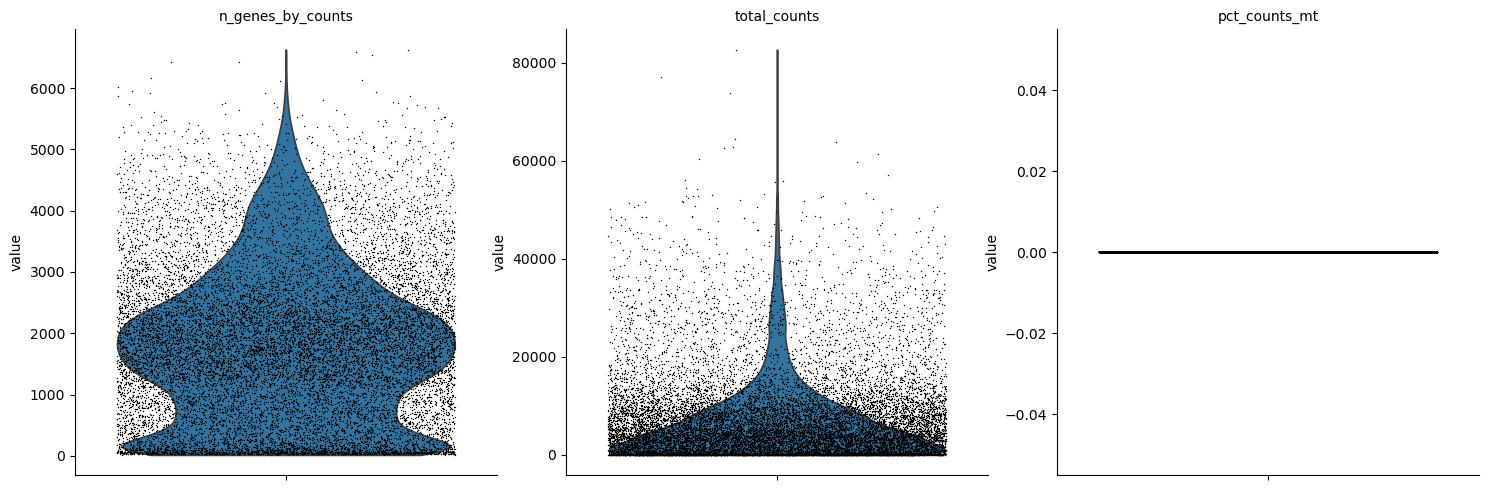

In [11]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [12]:
adata

AnnData object with n_obs × n_vars = 16787 × 36601
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [13]:
sc.pp.filter_cells(adata, min_genes=500)

In [14]:
sc.pp.filter_genes(adata, min_cells=3)

#### Doublet removal:

In [15]:
sc.pp.scrublet(adata, batch_key="Sample")

In [16]:
# Find the number of predicted doublets
num_predicted_doublets = (adata.obs['predicted_doublet'] == True).sum()
print(f"Number of predicted doublets: {num_predicted_doublets}")

Number of predicted doublets: 217


In [17]:
adata.shape

(13749, 22999)

In [18]:
adata = adata[adata.obs["predicted_doublet"] == False, :] 

In [19]:
adata

View of AnnData object with n_obs × n_vars = 13532 × 22999
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

#### Normalisation: 

In [20]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

/tmp/ipykernel_283099/2262359327.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [21]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)

In [22]:
# Logarithmize the data
sc.pp.log1p(adata)

#### Highly variable genes:

Calculate HVGs but no feature selection to ensure all mitochondrial genes may be analysed

In [23]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="Sample")

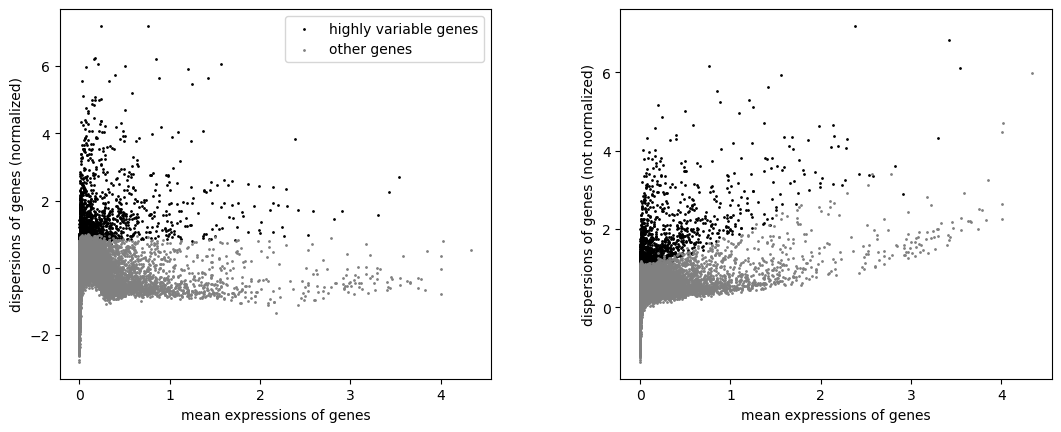

In [24]:
sc.pl.highly_variable_genes(adata)

#### Dimensionality reduction:

In [25]:
sc.tl.pca(adata)

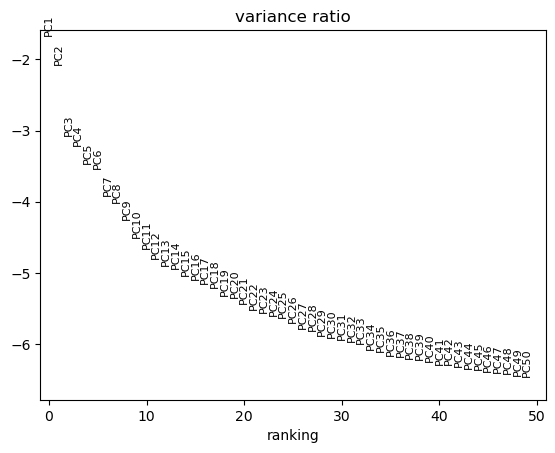

In [26]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

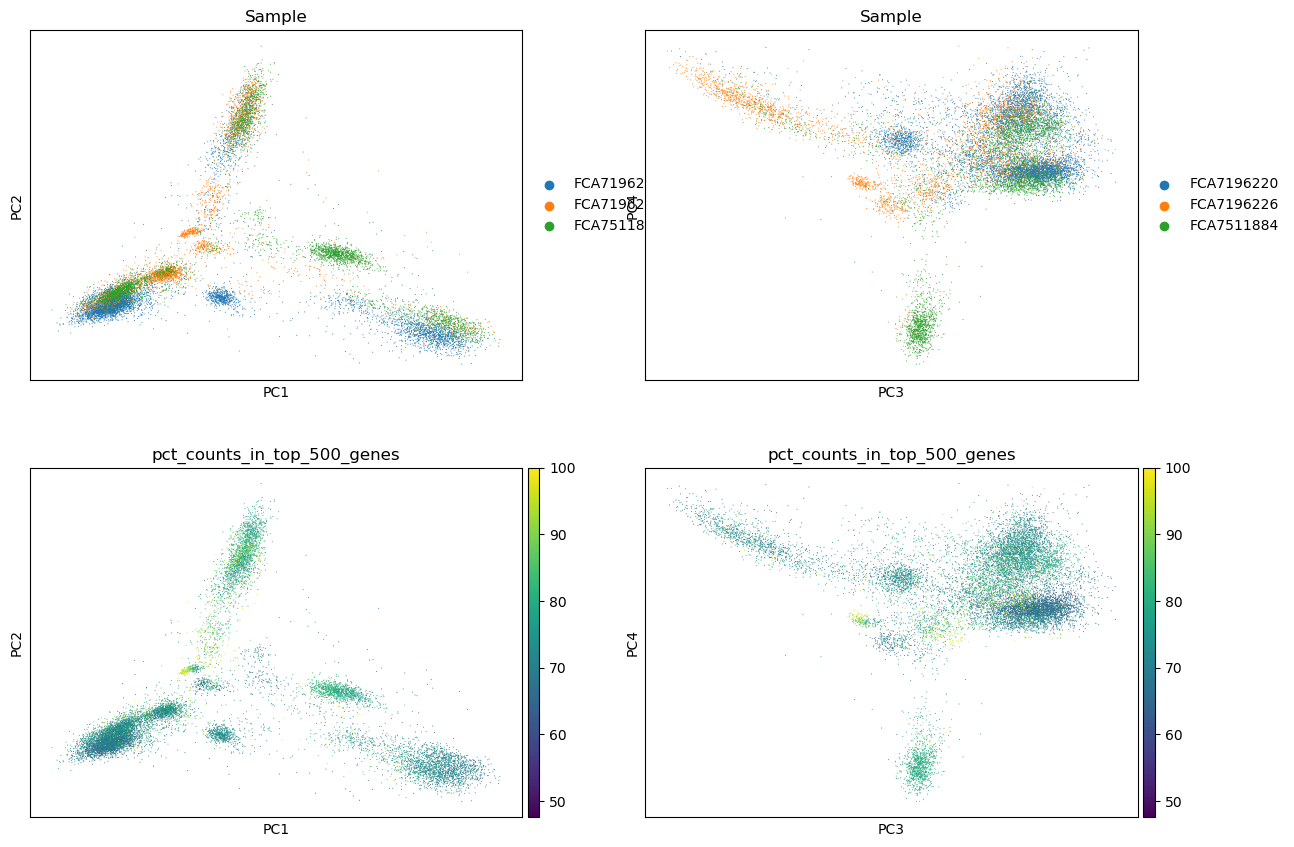

In [27]:
sc.pl.pca(
    adata,
    color=["Sample", "Sample", "pct_counts_in_top_500_genes", "pct_counts_in_top_500_genes"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

#### Batch correction:

In [28]:
import scanpy.external as sce

In [29]:
sce.pp.harmony_integrate(adata, key='Sample')

2025-04-15 13:33:46,622 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-15 13:33:48,432 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-15 13:33:48,463 - harmonypy - INFO - Iteration 1 of 10
2025-04-15 13:33:50,570 - harmonypy - INFO - Iteration 2 of 10
2025-04-15 13:33:52,665 - harmonypy - INFO - Iteration 3 of 10
2025-04-15 13:33:54,762 - harmonypy - INFO - Converged after 3 iterations


In [30]:
'X_pca_harmony' in adata.obsm

True

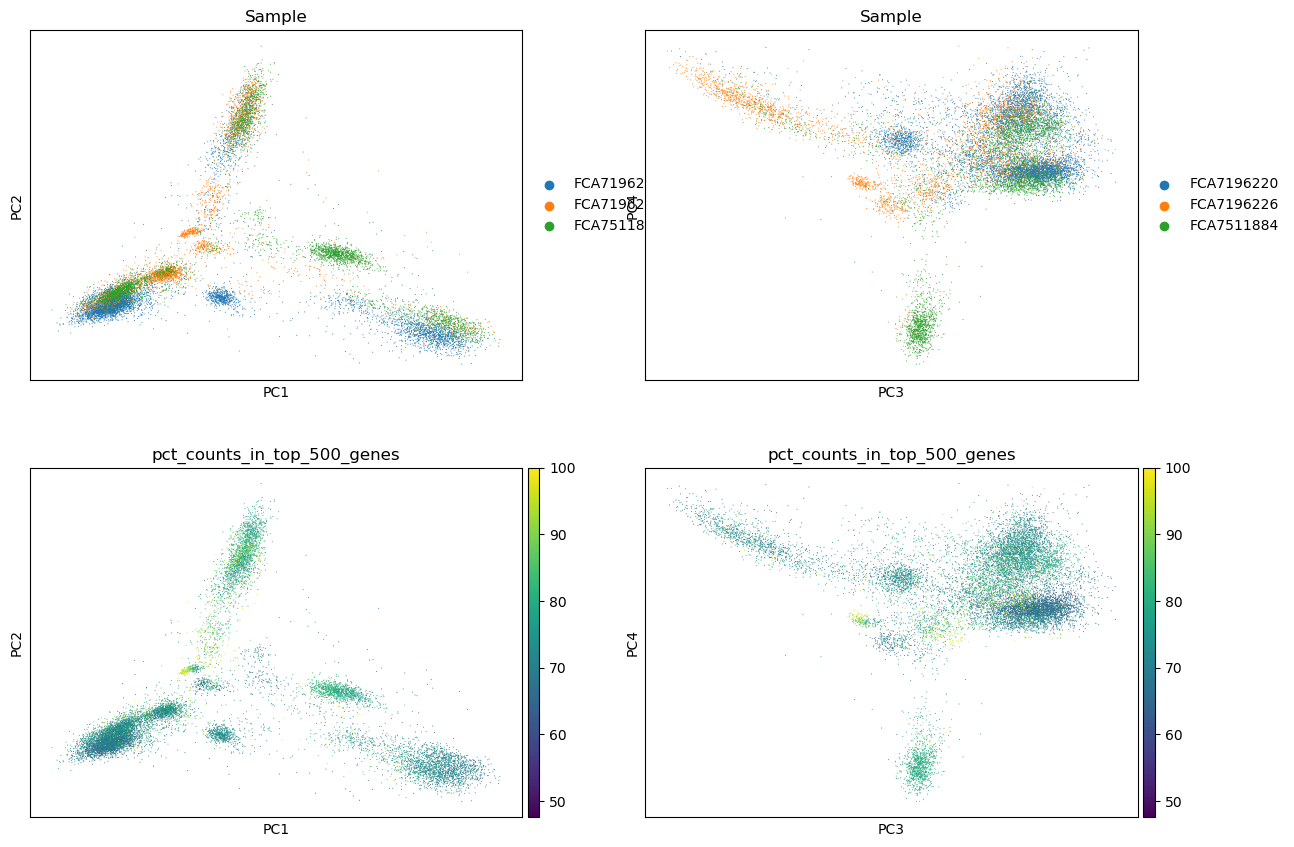

In [31]:
sc.pl.pca(
    adata,
    color=["Sample", "Sample", "pct_counts_in_top_500_genes", "pct_counts_in_top_500_genes"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

#### Compute neighborhood graph:

In [32]:
sc.pp.neighbors(adata, use_rep="X_pca_harmony")

In [33]:
sc.tl.umap(adata)

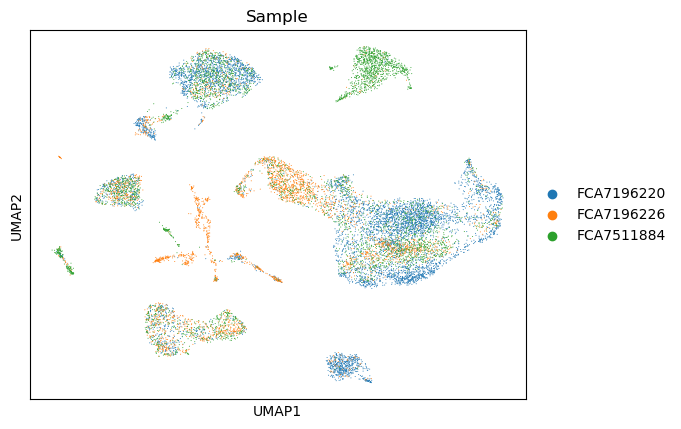

In [34]:
sc.pl.umap(
    adata,
    color="Sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

In [35]:
adata.write('vt_15.04.h5ad')

#### Extras: visualisation

In [48]:
adata = ad.read_h5ad('./vt_15.04.h5ad')

In [49]:
sc.tl.umap(adata)

In [50]:
sc.tl.leiden(adata, flavor="igraph", resolution=0.6, n_iterations=2)

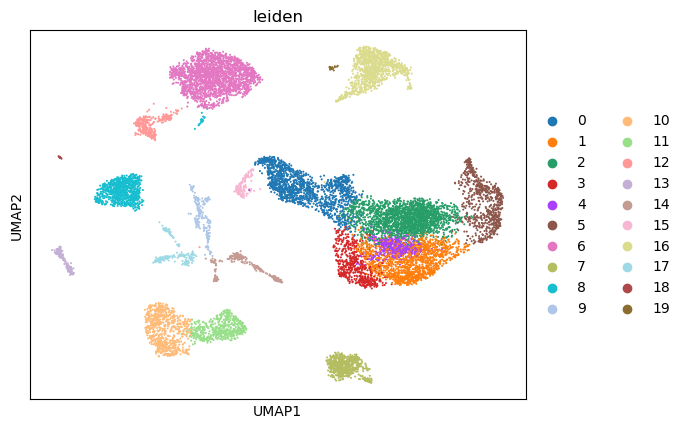

In [51]:
sc.pl.umap(adata, color=["leiden"])

In [52]:
# Compute PAGA
sc.tl.paga(adata, groups='leiden')

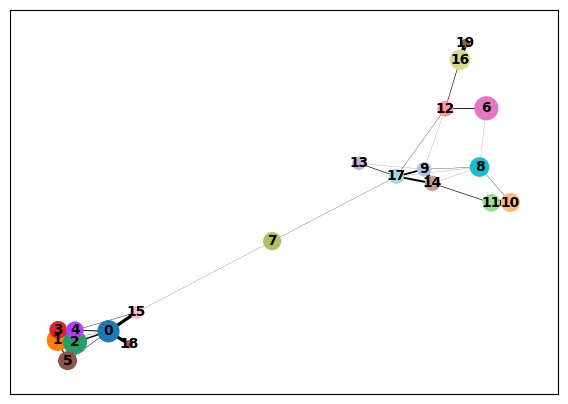

In [53]:
# plot PAGA connectivity 
sc.pl.paga(adata, plot=True)

In [54]:
#Compute UMAP with PAGA
sc.tl.umap(adata, min_dist=0.7, spread=0.8, init_pos='paga')

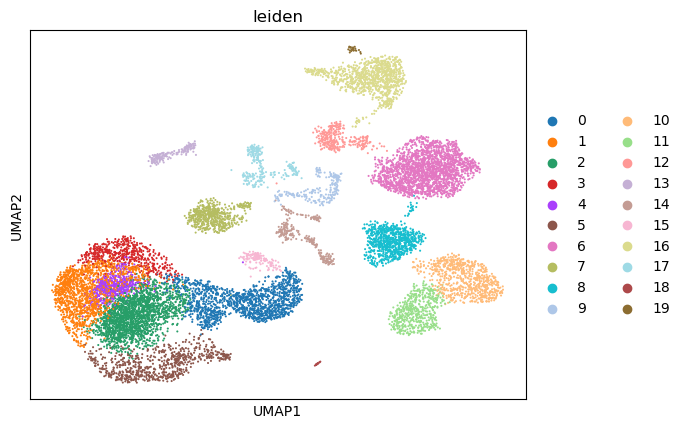

In [55]:
sc.pl.umap(adata, color='leiden')

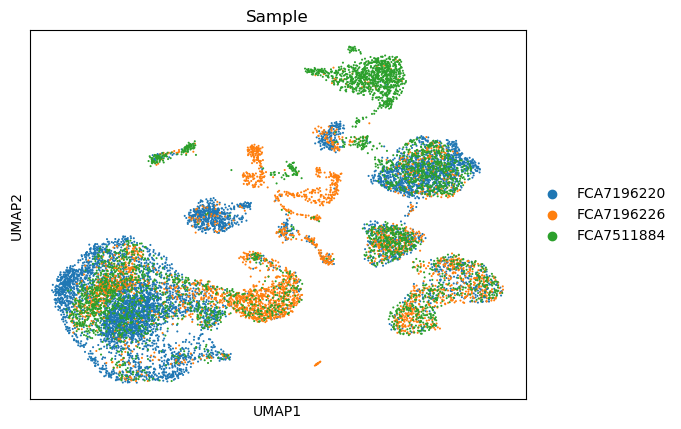

In [56]:
sc.pl.umap(adata, color="Sample")

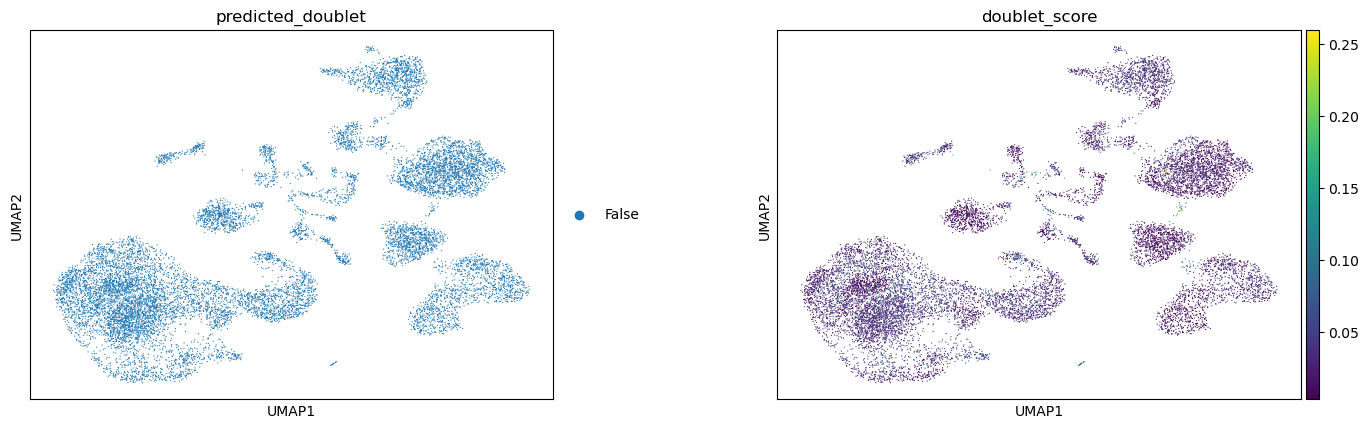

In [57]:
sc.pl.umap(
    adata,
    color=[ "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.3,
    size=3,
)

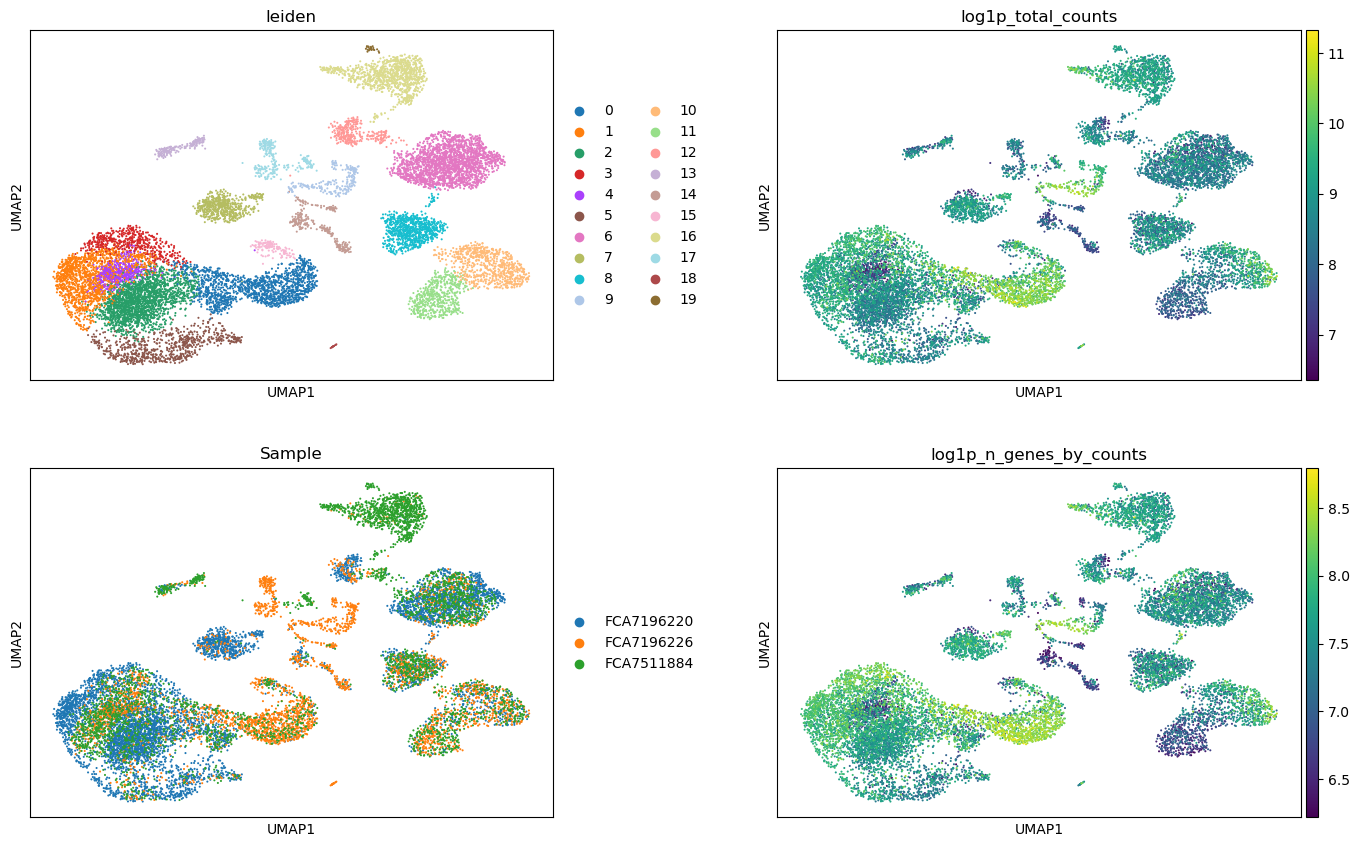

In [58]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "Sample", "log1p_n_genes_by_counts"],
    wspace=0.3,
    ncols=2,
)

In [59]:
# adata.write('vt_processed_19.03.h5ad')